In [22]:
import numpy as np
import pandas as pd
import scipy

'''

We will conduct A/B testing of click-through rates and conversions of two versions of sites

Dataset is taken from Kaggle (https://www.kaggle.com/datasets/zhangluyuan/ab-testing)

This data set contains the test result, during which the two groups,
control and experimental, viewed the old web page and the new web page, respectively.
The purpose of this test was to determine whether a new web page resulted in a significant increase in the number of
conversions compared to the old web page. Each row represents a unique user and shows
whether they belong to the control or experimental group, and whether they converted or not.

Because we're doing an A/B test for conversions, which is a categorical variable,
corresponding to the Bernoulli distribution, we will use the chi-square test

'''

df = pd.read_csv('data/ab_data.csv')

# We check the purity of the data. That is, are there any users in the control group who have seen the new page,
# and whether there are users from the experimental group who have seen the old page.df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [23]:
# It turned out that there is. Gotta fix it.
df_cleaned = df.loc[(df['group'] == 'control') & (df['landing_page'] == 'old_page')|
                    (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')
                    ]
df_cleaned.groupby(['group', 'landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [24]:
#Next, we check the uniqueness of users
df_cleaned['user_id'].duplicated().sum()

1

In [25]:
# It turned out that 1 duplicate is still there. Let's see who it is
df_cleaned[df_cleaned.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [26]:
# Let's remove it so it doesn't get in the way
df_cleaned = df_cleaned.drop_duplicates(subset='user_id', keep='first')
df_cleaned['user_id'].duplicated().sum()

0

<AxesSubplot:xlabel='group,landing_page,converted'>

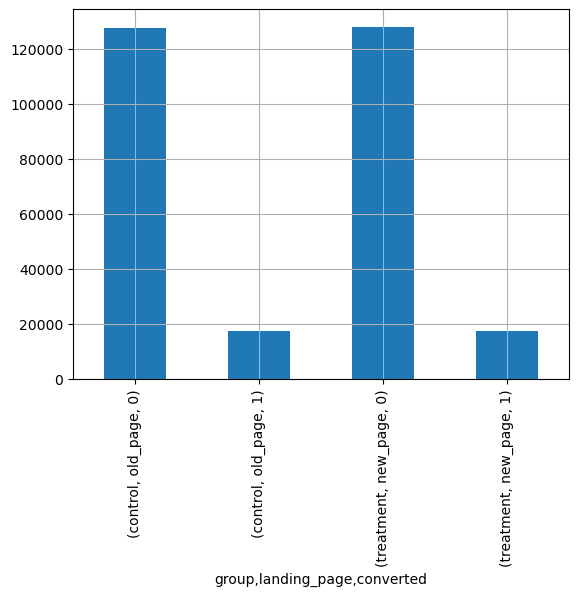

In [27]:
# Let's see the share of conversions in each group
group = df_cleaned.groupby(['group', 'landing_page', 'converted']).size()
group.plot.bar(grid=True)

<AxesSubplot:ylabel='landing_page'>

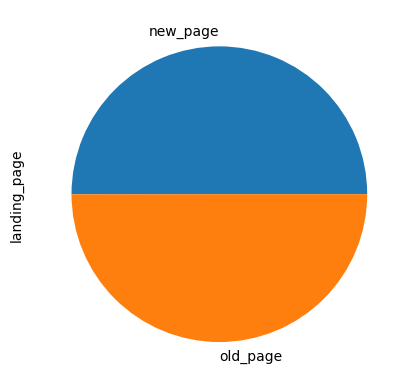

In [28]:
#Let's look at whether users are equally divided in groups
df_cleaned['landing_page'].value_counts().plot.pie()

In [29]:
# Data prepared. Now we can move on to the calculations

# First, let's divide our users into 2 groups
control = df_cleaned[df_cleaned['group'] == 'control']
treatment = df_cleaned[df_cleaned['group'] == 'treatment']

# Calculate for each group the number of converted (click)
# and non-converted (noclick) users
control_click = control.converted.sum()
control_noclick = control.converted.size - control_click
treatment_click = treatment.converted.sum()
treatment_noclick = treatment.converted.size - treatment_click

# Create an array
T = np.array([[control_click, control_noclick], [treatment_click, treatment_noclick]])

In [30]:
# Calculqting p-value
scipy.stats.chi2_contingency(T, correction=False)[1]

0.18988337448194853

In [31]:
'''
The calculated p is ~ 18.99%. Assuming a significance level of even 5%, we get,
that our p-value is much higher than alpha and therefore we do not reject null
hypothesis. Which means that the conversion difference between the old and new web pages is not significant.

'''

# Let's check the results. Calculate the conversion rates of the two groups
control_CTR = control_click / (control_click + control_noclick)
treatment_CTR = treatment_click / (treatment_click + treatment_noclick)

print('control CTR', control_CTR)
print('treatment CTR', treatment_CTR)

control CTR 0.1203863045004612
treatment CTR 0.11880806551510564


In [ ]:
#The difference between the coefficients is minimal